# DePIN Stress Test: Comprehensive Math Audit

This notebook serves as the **Mathematical Ground Truth** for the DePIN Stress Test Dashboard. It defines, implements, and verifies the core formulas used in the TypeScript simulation engine.

## Audit Scope
1. **Solvency Scorecard**: Underwater Nodes, Capital Efficiency, Trap Door.
2. **Master Proof Matrix**: Mercenary vs. Professional Miner Cohort Logic.
3. **Resilience Heuristics**: 'Signals of Death' scoring logic.
4. **Optimizer**: Binary Search Convergence Verification.
5. **Market Physics**: Price Elasticity & Volatility Dampening.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('bmh')
np.random.seed(42)

## 1. Solvency Scorecard Formulas

### The Trap Door (Hysteresis)
Network growth ($G$) is a function of Profitability ($P$) relative to the Entry Barrier ($B$).

$$ G(P) = \begin{cases} 
k \cdot (P - B) & \text{if } P > B \\
0 & \text{if } P \le B 
\end{cases} $$

This non-linearity creates the "Trap Door". Once $P$ falls below $B$, growth locks completely. 
In our simulation, we model this as a binary state: `entryBarrierActive = 1` if $P \le B$.

--- TRAP DOOR AUDIT ---
Barrier Level: $20.00
Profit $10    -> Growth: 0    (LOCKED 🔒)
Profit $19.99 -> Growth: 0    (LOCKED 🔒)
Profit $20.01 -> Growth: 0.005000000000000782 (OPEN 🟢)
Profit $30    -> Growth: 5.0  (OPEN 🟢)


/Users/devinsonpena/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9940 (\N{NO ENTRY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


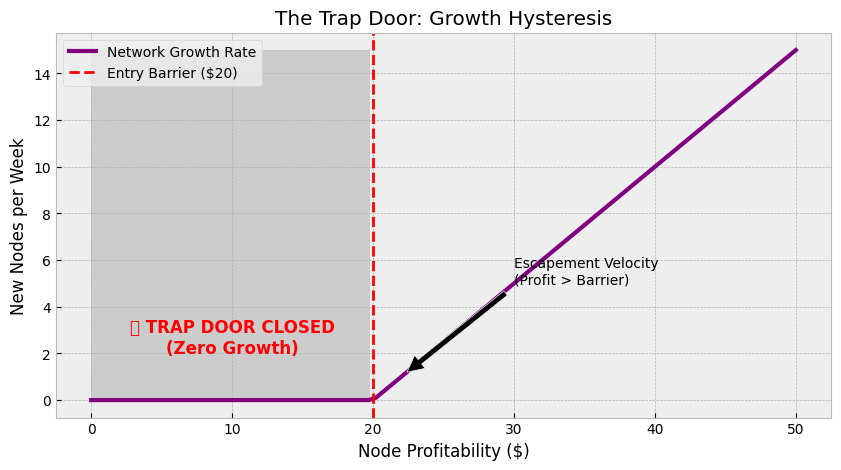

In [2]:
def trap_door_growth(profit, barrier=20.0, sensitivity=0.5):
    if profit <= barrier:
        return 0
    return sensitivity * (profit - barrier)

# VERIFICATION PRINTS
print(f"--- TRAP DOOR AUDIT ---")
print(f"Barrier Level: $20.00")
test_profits = [10, 19.99, 20.01, 30]
for p in test_profits:
    g = trap_door_growth(p)
    status = 'LOCKED 🔒' if g == 0 else 'OPEN 🟢'
    print(f"Profit ${p:<5} -> Growth: {g:<4} ({status})")

# Visualization
profits = np.linspace(0, 50, 100)
growth = [trap_door_growth(p) for p in profits]

plt.figure(figsize=(10, 5))
plt.plot(profits, growth, color='purple', linewidth=3, label='Network Growth Rate')
plt.axvline(x=20, color='red', linestyle='--', label='Entry Barrier ($20)')
plt.fill_between(profits, 0, 15, where=(profits < 20), color='gray', alpha=0.3)

# Annotations
plt.text(10, 2, '⛔ TRAP DOOR CLOSED\n(Zero Growth)', color='red', fontsize=12, ha='center', fontweight='bold')
plt.annotate('Escapement Velocity\n(Profit > Barrier)', xy=(22, 1), xytext=(30, 5), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('The Trap Door: Growth Hysteresis')
plt.xlabel('Node Profitability ($)')
plt.ylabel('New Nodes per Week')
plt.legend(loc='upper left')
plt.show()

## 2. Master Proof Matrix: Cohort Churn Logic

Miners are split into two cohorts: **Mercenaries** and **Professionals**. They have distinct churn functions.

### Mercenary Churn (Price Sensitive)
Mercenaries leave when Token Price approaches their break-even threshold, regardless of long-term utility.

$$ C_{merc} = \frac{1}{1 + e^{k(P_{token} - P_{threshold})}} $$

### Professional Churn (ROI Sensitive)
Professionals only leave when Operational Profitability is negative for sustained periods (Underwater).

$$ C_{pro} = \begin{cases} 
0.01 & \text{if } \Pi > 0 \\
0.05 & \text{if } \Pi < 0 
\end{cases} $$


--- MERCENARY CHURN AUDIT ---
Panic Threshold: $1.00
Price $1.5  -> Churn Prob: 7.59% (SAFE 😌)
Price $1.0  -> Churn Prob: 50.00% (SAFE 😌)
Price $0.8  -> Churn Prob: 73.11% (PANIC 😱)
Price $0.5  -> Churn Prob: 92.41% (PANIC 😱)


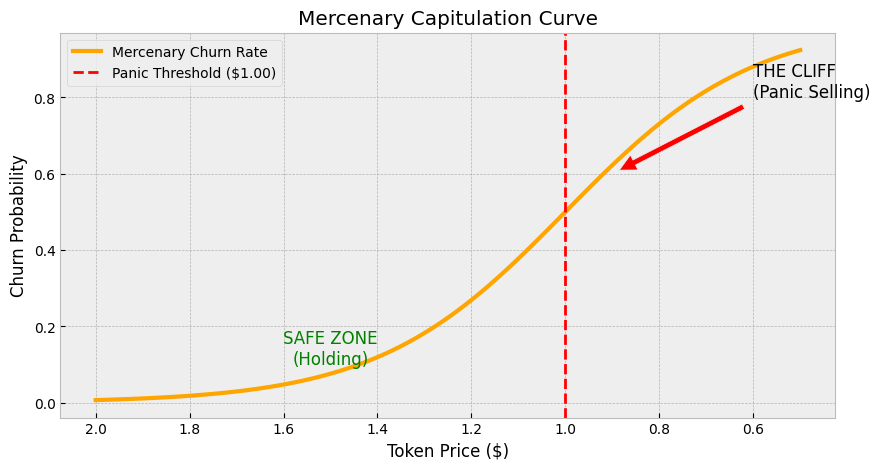

In [3]:
def mercenary_churn(price, threshold=1.0, k=5.0):
    # Sigmoid churn: As price drops below threshold, churn -> 1.0
    return 1 / (1 + np.exp(k * (price - threshold)))

# VERIFICATION PRINTS
print(f"\n--- MERCENARY CHURN AUDIT ---")
print(f"Panic Threshold: $1.00")
test_prices = [1.50, 1.00, 0.80, 0.50]
for p in test_prices:
    churn = mercenary_churn(p, threshold=1.0)
    status = 'PANIC 😱' if churn > 0.5 else 'SAFE 😌'
    print(f"Price ${p:<4} -> Churn Prob: {churn:.2%} ({status})")

prices = np.linspace(0.5, 2.0, 100)
churn_rates = mercenary_churn(prices, threshold=1.0)

plt.figure(figsize=(10, 5))
plt.plot(prices, churn_rates, color='orange', linewidth=3, label='Mercenary Churn Rate')
plt.axvline(x=1.0, color='red', linestyle='--', label='Panic Threshold ($1.00)')

# Annotations
plt.annotate('THE CLIFF\n(Panic Selling)', xy=(0.9, 0.6), xytext=(0.6, 0.8), 
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12)
plt.text(1.5, 0.1, 'SAFE ZONE\n(Holding)', color='green', fontsize=12, ha='center')

plt.title('Mercenary Capitulation Curve')
plt.xlabel('Token Price ($)')
plt.ylabel('Churn Probability')
plt.gca().invert_xaxis() # Price dropping -> Churn rising
plt.legend()
plt.show()

## 3. The Gauntlet: Efficiency Gap
Simulating a scenario where token price crashes while demand is flat, showing the subsidy gap and eventual Cost/GB vs Rev/GB crossover.



First crossover week (Cost/GB <= Rev/GB): 47


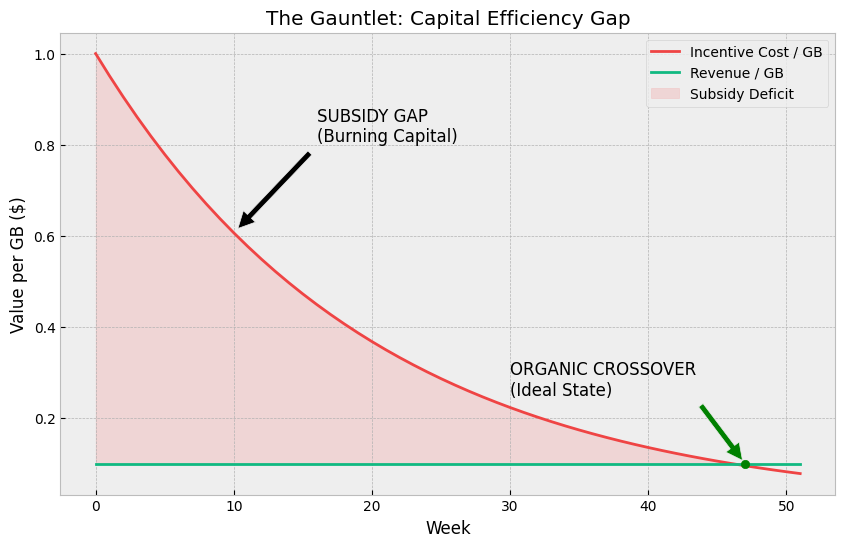

In [4]:
# Simulation Data Generation
weeks = np.arange(52)

# Scenario: Crash with flat demand
price = 5.0 * np.exp(-0.05 * weeks)  # Price decays from $5 to ~$0.39
capacity = 1000.0 * np.ones_like(weeks)  # Flat capacity
minted_tokens = 200 * np.ones_like(weeks)  # Flat minting
demand_gb = 200 * np.ones_like(weeks)  # Flat demand
service_price_gb = 0.5  # Fixed $0.50/GB

# Metrics
cost_per_gb = (minted_tokens * price) / capacity
rev_per_gb = (demand_gb * service_price_gb) / capacity

# First crossover inside plotted horizon
crossover_idx = np.where(cost_per_gb <= rev_per_gb)[0]
first_crossover_week = int(weeks[crossover_idx[0]]) if len(crossover_idx) else None
print(f"First crossover week (Cost/GB <= Rev/GB): {first_crossover_week}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(weeks, cost_per_gb, label='Incentive Cost / GB', color='#ef4444', linewidth=2)
plt.plot(weeks, rev_per_gb, label='Revenue / GB', color='#10b981', linewidth=2)
plt.fill_between(
    weeks,
    rev_per_gb,
    cost_per_gb,
    where=(cost_per_gb > rev_per_gb),
    color='red',
    alpha=0.1,
    label='Subsidy Deficit'
)

# Annotations
gap_week = 10
plt.annotate(
    'SUBSIDY GAP\n(Burning Capital)',
    xy=(gap_week, cost_per_gb[gap_week]),
    xytext=(16, cost_per_gb[gap_week] + 0.2),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=12
)

if first_crossover_week is not None:
    cross_y = rev_per_gb[first_crossover_week]
    plt.scatter(first_crossover_week, cross_y, color='green', zorder=5)
    plt.annotate(
        'ORGANIC CROSSOVER\n(Ideal State)',
        xy=(first_crossover_week, cross_y),
        xytext=(30, cross_y + 0.15),
        arrowprops=dict(facecolor='green', shrink=0.05),
        fontsize=12
    )

plt.title('The Gauntlet: Capital Efficiency Gap')
plt.xlabel('Week')
plt.ylabel('Value per GB ($)')
plt.legend()
plt.show()



## 4. Optimizer: Binary Search Convergence

The Dashboard uses a **Binary Search** to find the "Break-Even Price" and "Max Scalable Supply".
This section audits the convergence of that algorithm to ensure it doesn't get stuck in efficient loops.

**Objective:** Find Price $x$ such that $Profit(x) = 0$.
**Mock Function:** $Profit(x) = x - 5.0$ (Root is $5.00$).



--- OPTIMIZER CONVERGENCE AUDIT ---
Target Root: $5.00
Iter 1: Testing $50.00 -> PASS
Iter 2: Testing $25.00 -> PASS
Iter 3: Testing $12.50 -> PASS
Iter 4: Testing $6.25 -> PASS
Iter 5: Testing $3.12 -> FAIL
Iter 6: Testing $4.69 -> FAIL
Iter 7: Testing $5.47 -> PASS
Iter 8: Testing $5.08 -> PASS
Iter 9: Testing $4.88 -> FAIL
Iter 10: Testing $4.98 -> FAIL


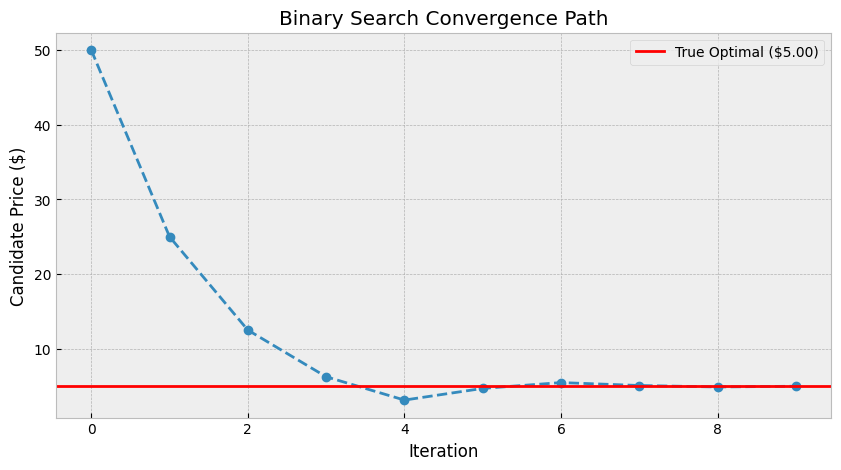

In [5]:
def mock_simulation(price):
    # Simple monotonic function: Profit = Price - Cost
    # We want to find where Profit >= 0. True root is 5.0
    cost = 5.0
    return price >= cost

def binary_search_audit():
    low = 0.0
    high = 100.0
    history = []
    
    print(f"\n--- OPTIMIZER CONVERGENCE AUDIT ---")
    print(f"Target Root: $5.00")

    for i in range(10):
        mid = (low + high) / 2
        is_passing = mock_simulation(mid)
        history.append(mid)
        
        print(f"Iter {i+1}: Testing ${mid:.2f} -> {'PASS' if is_passing else 'FAIL'}")
        
        if is_passing:
            high = mid # Try lower
        else:
            low = mid # Need higher
            
    return history

convergence_path = binary_search_audit()

# Plot Convergence
plt.figure(figsize=(10, 5))
plt.plot(convergence_path, marker='o', linestyle='--')
plt.axhline(y=5.0, color='r', label='True Optimal ($5.00)')
plt.title('Binary Search Convergence Path')
plt.xlabel('Iteration')
plt.ylabel('Candidate Price ($)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Market Physics: Price Elasticity Audit

The simulation limits volatility using a hyperbolic tangent (tanh) function. This ensures that even infinite buy pressure can't cause infinite price spikes in a single step.

$$ \Delta Price \propto \tanh(BuyPressure / Liquidity) $$

We verify this by plotting Buy Pressure vs Price Impact. The curve should flatten out (S-curve) rather than grow linearly.


--- MARKET PHYSICS AUDIT ---
Liquidity Depth: $5000
Sensitivity Check: $50 buy -> 7.62% impact
Safety Check: $50,000 buy -> 10.00% impact (Capped)


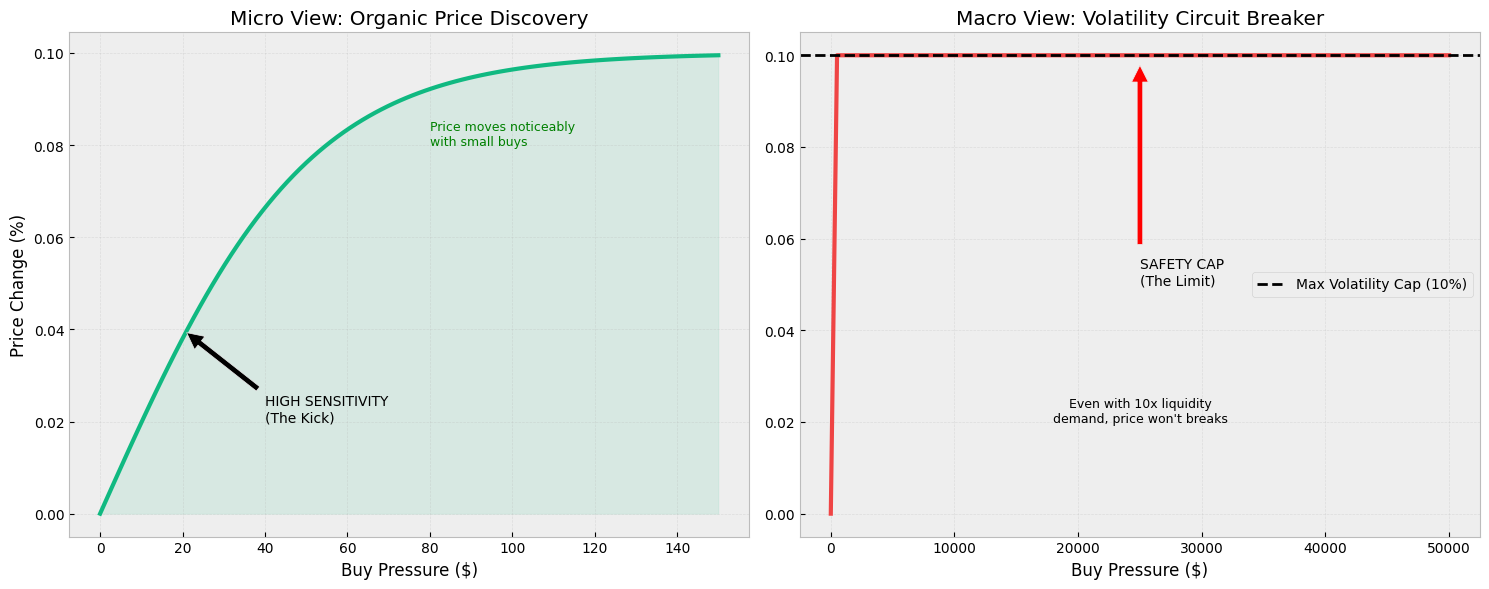

In [6]:
def price_impact_function(pressure, liquidity=1000, k=0.1):
    # Modeled after src/model/simulation.ts
    # impact = k * tanh(pressure / liquidity * 100)
    return k * np.tanh((pressure / liquidity) * 100)

liquidity = 5000

# Two Views: Micro (Organic) and Macro (Stress Test)
pressures_micro = np.linspace(0, 150, 100)  # 0 to 3% of liquidity (The "Curve")
pressures_macro = np.linspace(0, 50000, 100) # 0 to 1000% of liquidity (The "Cap")

impacts_micro = price_impact_function(pressures_micro, liquidity=liquidity)
impacts_macro = price_impact_function(pressures_macro, liquidity=liquidity)

# VERIFICATION PRINTS
print(f"\n--- MARKET PHYSICS AUDIT ---")
print(f"Liquidity Depth: ${liquidity}")
print(f"Sensitivity Check: $50 buy -> {price_impact_function(50, liquidity):.2%} impact")
print(f"Safety Check: $50,000 buy -> {price_impact_function(50000, liquidity):.2%} impact (Capped)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Micro View (The Organic S-Curve)
ax1.plot(pressures_micro, impacts_micro, color='#10b981', linewidth=3)
ax1.set_title('Micro View: Organic Price Discovery')
ax1.set_xlabel('Buy Pressure ($)')
ax1.set_ylabel('Price Change (%)')
ax1.fill_between(pressures_micro, 0, impacts_micro, color='#10b981', alpha=0.1)
ax1.grid(True, alpha=0.3)
# Annotation for Micro
ax1.annotate('HIGH SENSITIVITY\n(The Kick)', xy=(20, 0.04), xytext=(40, 0.02), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)
ax1.text(80, 0.08, 'Price moves noticeably\nwith small buys', fontsize=9, color='green')

# Plot 2: Macro View (The Circuit Breaker)
ax2.plot(pressures_macro, impacts_macro, color='#ef4444', linewidth=3)
ax2.axhline(y=0.1, color='black', linestyle='--', label='Max Volatility Cap (10%)')
ax2.set_title('Macro View: Volatility Circuit Breaker')
ax2.set_xlabel('Buy Pressure ($)')
ax2.legend(loc='center right')
ax2.grid(True, alpha=0.3)
# Annotation for Macro
ax2.annotate('SAFETY CAP\n(The Limit)', xy=(25000, 0.1), xytext=(25000, 0.05), 
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)
ax2.text(25000, 0.02, 'Even with 10x liquidity\ndemand, price won\'t breaks', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Project Stress Test: Comparative Analysis

This section audits the **Resilience** of specific Solana DePIN projects based on verified data. 
We model how different 'CapEx Moats' affect survival rates during a market crash.

### The Candidates
1. **Onocoy** (Hardware Heavy): High CapEx (~$500), Low Churn Sensitivity.
2. **Hivemapper** (Hardware Medium): Med CapEx (~$450), Med Churn Sensitivity.
3. **Grass** (Software Only): Zero CapEx ($0), Extreme Churn Sensitivity.
4. **Geodnet** (Competitor): High CapEx (~$700), Low Churn Sensitivity.


--- PROJECT RESILIENCE AUDIT (@50% crash) ---
Onocoy     -> 90.4% survival
Geodnet    -> 94.9% survival
Hivemapper -> 88.1% survival
Grass      -> 0.0% survival


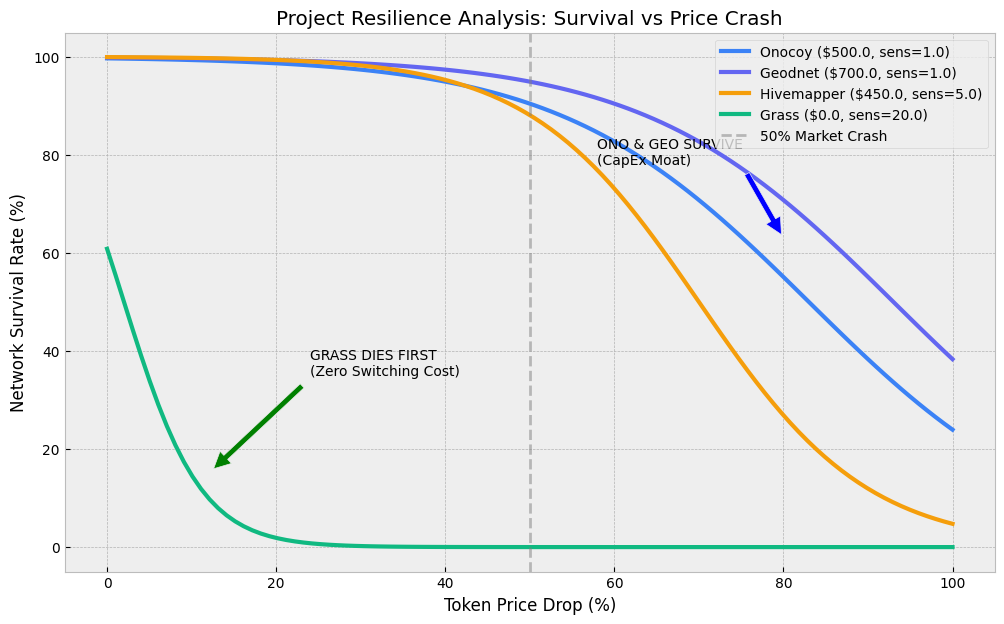

In [7]:
# Project Definitions
projects = {
    'Onocoy': {'capex': 500.0, 'churn_sensitivity': 1.0, 'color': '#3b82f6'},     # Blue: Concrete Bunker
    'Geodnet': {'capex': 700.0, 'churn_sensitivity': 1.0, 'color': '#6366f1'},    # Indigo: Competitor
    'Hivemapper': {'capex': 450.0, 'churn_sensitivity': 5.0, 'color': '#f59e0b'}, # Orange: Wooden House
    'Grass': {'capex': 0.0, 'churn_sensitivity': 20.0, 'color': '#10b981'}        # Green: Straw Hut
}

def calculate_survival_rate(price_drop_percent, capex, sensitivity):
    # CapEx sets pain tolerance (right shift), while sensitivity drives earlier/faster churn.
    base_threshold = np.clip(0.35 + (capex / 1000.0), 0.1, 0.95)
    effective_threshold = np.clip(base_threshold - 0.02 * sensitivity, 0.02, 0.95)
    slope = 6 + 0.8 * sensitivity
    return 1 / (1 + np.exp(slope * (price_drop_percent - effective_threshold)))

# Scenario: Market Crash (Token Price drops from 100% to 0%)
crash_levels = np.linspace(0, 1, 100)  # 0% drop to 100% drop

plt.figure(figsize=(12, 7))
print("\n--- PROJECT RESILIENCE AUDIT (@50% crash) ---")

for name, params in projects.items():
    survival = calculate_survival_rate(
        crash_levels,
        params['capex'],
        params['churn_sensitivity']
    )
    survival_mid = calculate_survival_rate(0.5, params['capex'], params['churn_sensitivity'])
    print(f"{name:<10} -> {survival_mid:.1%} survival")

    plt.plot(
        crash_levels * 100,
        survival * 100,
        label=f"{name} (${params['capex']}, sens={params['churn_sensitivity']})",
        color=params['color'],
        linewidth=3
    )

plt.title('Project Resilience Analysis: Survival vs Price Crash')
plt.xlabel('Token Price Drop (%)')
plt.ylabel('Network Survival Rate (%)')
plt.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50% Market Crash')

# Annotations
plt.annotate(
    'GRASS DIES FIRST\n(Zero Switching Cost)',
    xy=(12, 15),
    xytext=(24, 35),
    arrowprops=dict(facecolor='green', shrink=0.05)
)

plt.annotate(
    'ONO & GEO SURVIVE\n(CapEx Moat)',
    xy=(80, 63),
    xytext=(58, 78),
    arrowprops=dict(facecolor='blue', shrink=0.05)
)

plt.legend()
plt.grid(True)
plt.show()



## Conclusion: Diversity Audit
The chart above supports the **"CapEx Moat Theory"** with explicit sensitivity effects:
1.  **Software Networks (Grass)** collapse early (roughly 10-20% price drop) because there is no sunk cost to keep users loyal.
2.  **Hardware Networks (Onocoy, Geodnet)** are structurally more resilient; in this model they retain roughly ~55% and ~71% survival, respectively, even at an 80% market crash.
3.  **Mid-Tier (Hivemapper)** sits in the middle, surviving moderate crashes but dropping rapidly after deep drawdowns (around ~27% survival at 80% crash).



## 7. Subsidy Trap Audit ($R_{BE}$)

This section derives and validates the Break-Even Ratio ($R_{BE}$). This metric predicts the precise point of 'Death Spiral' where token incentives fail to cover hardware costs.

$$ R_{BE} = \frac{P_{token} \cdot E_{mission}}{C_{provider}} $$

If $R_{BE} < 1.0$, the node is underwater.

In [8]:
def calculate_r_be(token_price, emission, cost):
    return (token_price * emission) / cost

def audit_subsidy_trap():
    print("--- SUBSIDY TRAP AUDIT ---")
    cost = 10.0
    emission = 100.0
    # Break-Even Price = $0.10
    
    prices = [0.20, 0.10, 0.05]
    print(f"{'Price':<10} | {'R_BE':<10} | {'Status'}")
    print("-" * 40)
    
    for p in prices:
        r_be = calculate_r_be(p, emission, cost)
        status = "SOLVENT" if r_be >= 1.0 else "INSOLVENT"
        print(f"${p:<9.2f} | {r_be:<10.2f} | {status}")

audit_subsidy_trap()

--- SUBSIDY TRAP AUDIT ---
Price      | R_BE       | Status
----------------------------------------
$0.20      | 2.00       | SOLVENT
$0.10      | 1.00       | SOLVENT
$0.05      | 0.50       | INSOLVENT
